In [1]:
from tqdm import tqdm
from glob import glob
from matplotlib.colors import ListedColormap
from EmbedSeg.utils.preprocess_data import extract_data, split_train_val, get_data_properties, keep_subset_train
from EmbedSeg.utils.generate_crops import *
from EmbedSeg.utils.visualize import visualize_many_crops, visualize
from EmbedSeg.train import begin_training
from EmbedSeg.utils.create_dicts import create_dataset_dict, create_model_dict, create_loss_dict, create_configs, create_test_configs_dict
from EmbedSeg.test import begin_evaluating
import tifffile, numpy as np, os, json, torch
%matplotlib inline

<div class="alert alert-block alert-info"> <b> A typical setup for fine-tuning is that one has a few labels on one's dataset of interest and then finds a model, pretrained on similar-looking data. </b> <br>
In this notebook, we test this scenario by using the model pretrained on the <i>DSB</i> nuclei dataset and fine-tuning those model weights on the <i>GFP-GOWT1 mouse stem cell nuclei</i> available on the <a href = "http://celltrackingchallenge.net/2d-datasets/"> cell-tracking-challenge </a> website. <br>
To simulate that we have only a few labels, we keep labels for only <b>10 % </b> train images. 

### Download data

>The images and corresponding masks are downloaded from an external url, specified by `zip_url` to the path specified by the variables `data_dir` and `project_name`, using `extract_data` function. 
Next, the `train` directories are split into `train` and `val` using `split_train_val`.

In [2]:
data_dir = '../../data'
project_name = 'Fluo-N2DH-GOWT1'

In [3]:
extract_data(
    zip_url = 'https://github.com/juglab/EmbedSeg/releases/download/v0.1.0/Fluo-N2DH-GOWT1.zip',
    data_dir = data_dir,
    project_name = project_name)

Downloaded data as ../../data/Fluo-N2DH-GOWT1.zip
Unzipped data to ../../data/Fluo-N2DH-GOWT1/download/


In [4]:
split_train_val(
    data_dir = data_dir,
    project_name = project_name, 
    train_val_name = 'train',
    subset = 0.15)

Created new directory : ../../data/Fluo-N2DH-GOWT1/train/images/
Created new directory : ../../data/Fluo-N2DH-GOWT1/train/masks/
Created new directory : ../../data/Fluo-N2DH-GOWT1/val/images/
Created new directory : ../../data/Fluo-N2DH-GOWT1/val/masks/
Created new directory : ../../data/Fluo-N2DH-GOWT1/test/images/
Created new directory : ../../data/Fluo-N2DH-GOWT1/test/masks/
Train-Val-Test Images/Masks copied to ../../data/Fluo-N2DH-GOWT1


In [5]:
keep_subset_train(data_dir = data_dir,
    project_name = project_name, 
    train_name = 'train', subset= 0.10)

### Specify desired centre location for spatial embedding of pixels

>Interior pixels of an object instance can either be embedded at the `medoid`, the `approximate-medoid` or the `centroid`.

In [6]:
center = 'medoid' # 'medoid', 'approximate-medoid', 'centroid'

### Calculate some dataset specific properties

>In the next cell, we will calculate properties of the data such as `min_object_size`, `foreground_weight` etc. 
We can also specify some properties, for example, set `data_properties_dir['data_type']='16-bit'` if the images are of datatype `unsigned 16 bit` and `data_properties_dir['data_type']='8-bit'` if the images are of datatype `unsigned 8 bit`.

In [7]:
data_properties_dir = get_data_properties(data_dir, project_name, train_val_name=['train', 'val'], 
                                          test_name=['test'], mode='2d')

data_properties_dir['data_type']='8-bit'
data_type, foreground_weight, n_y, n_x, min_object_size = data_properties_dir['data_type'], int(data_properties_dir['foreground_weight']), int(data_properties_dir['n_y']), int(data_properties_dir['n_x']), int(data_properties_dir['min_object_size'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 105.18it/s]


Foreground weight of the `Fluo-N2DH-GOWT1` dataset set equal to 10.000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 13.44it/s]


Minimum object size of the `Fluo-N2DH-GOWT1` dataset is equal to 920
Mean object size of the `Fluo-N2DH-GOWT1` dataset is equal to 3230.592105263158
Maximum object size of the `Fluo-N2DH-GOWT1` dataset is equal to 5533.2699999999995
Average object size of the `Fluo-N2DH-GOWT1` dataset along `x` is equal to 63.239
Std. dev object size of the `Fluo-N2DH-GOWT1` dataset along `x` is equal to 8.183
Average object size of the `Fluo-N2DH-GOWT1` dataset along `y` is equal to 64.011
Std. dev object size of the `Fluo-N2DH-GOWT1` dataset along `y` is equal to 9.764


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:01<00:00, 77.38it/s]


Tile size of the `Fluo-N2DH-GOWT1` dataset set equal to (1024, 1024)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 52.76it/s]

Average background intensity of the `Fluo-N2DH-GOWT1` dataset set equal to 1.469


### Specify cropping configuration parameters

>Images and the corresponding masks are cropped into patches centred around an object instance, which are pre-saved prior to initiating the training. Note that the cropped images, masks and center-images would be saved at the path specified by `crops_dir` (The parameter `crops_dir` is set to ```./crops``` by default, which creates a directory at the same location as this notebook). 
Note that we automatically calculate  the `crop_size` by using the `avg_object_size` and `std_object_size` through the relation:  
$\text{crop_size_i} = \text{avg_obj_size_i} + \text{n_sigma} \times \text{std_obj_size_i}$ where $i \in \{x,y\}$ and `n_sigma` equals `5` by default.  
Please feel free to reduce the parameter `n_sigma` to be equal to `3-4` in case of lower GPU memory.

In [8]:
n_sigma = 5

In [9]:
def round_up_8(x):
    return (x.astype(int)+7) & (-8)

In [10]:
crops_dir = './crops'
crop_size = np.maximum(round_up_8(data_properties_dir['avg_object_size_y'] + n_sigma*data_properties_dir['stdev_object_size_y']),
round_up_8(data_properties_dir['avg_object_size_x'] + n_sigma*data_properties_dir['stdev_object_size_x']))
print("Crop size in x and y will be set equal to {}".format(crop_size))

Crop size in x and y will be set equal to 112


### Generate Crops

>Images are normalized using `min-max-percentile` scheme (by default) and then cropped and saved using the `process` method. Other options for normalization are `absolute` and `mean-std`. Here, `data_subsets` defines the directories which are processed.  

In [11]:
norm = 'min-max-percentile' # min-max-percentile, absolute, mean-std, 

In [12]:
data_subsets = ['train', 'val'] 
for data_subset in data_subsets:
    image_dir = os.path.join(data_dir, project_name, data_subset, 'images')
    instance_dir = os.path.join(data_dir, project_name, data_subset, 'masks')
    image_names = sorted(glob(os.path.join(image_dir, '*.tif'))) 
    instance_names = sorted(glob(os.path.join(instance_dir, '*.tif')))  
    for i in tqdm(np.arange(len(image_names))):
        process(image_names[i], instance_names[i], os.path.join(crops_dir, project_name), data_subset, crop_size, center, norm=norm, data_type = data_properties_dir['data_type'])
    print("Cropping of images, instances and centre_images for data_subset = `{}` done!".format(data_subset))

  0%|                                                                                                                       | 0/8 [00:00<?, ?it/s]

Created new directory : ./crops/Fluo-N2DH-GOWT1/train/images/
Created new directory : ./crops/Fluo-N2DH-GOWT1/train/masks/
Created new directory : ./crops/Fluo-N2DH-GOWT1/train/center-medoid/


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:19<00:00,  2.40s/it]


Cropping of images, instances and centre_images for data_subset = `train` done!


  0%|                                                                                                                      | 0/13 [00:00<?, ?it/s]

Created new directory : ./crops/Fluo-N2DH-GOWT1/val/images/
Created new directory : ./crops/Fluo-N2DH-GOWT1/val/masks/
Created new directory : ./crops/Fluo-N2DH-GOWT1/val/center-medoid/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:26<00:00,  2.06s/it]

Cropping of images, instances and centre_images for data_subset = `val` done!


### Visualize cropped images, corresponding ground truth masks and object center images 

>Some of these cropped images generated above, their label masks and the center-images are visualized.  
The label masks are colored with a glasbey-style color map stored in `new_cmap`.

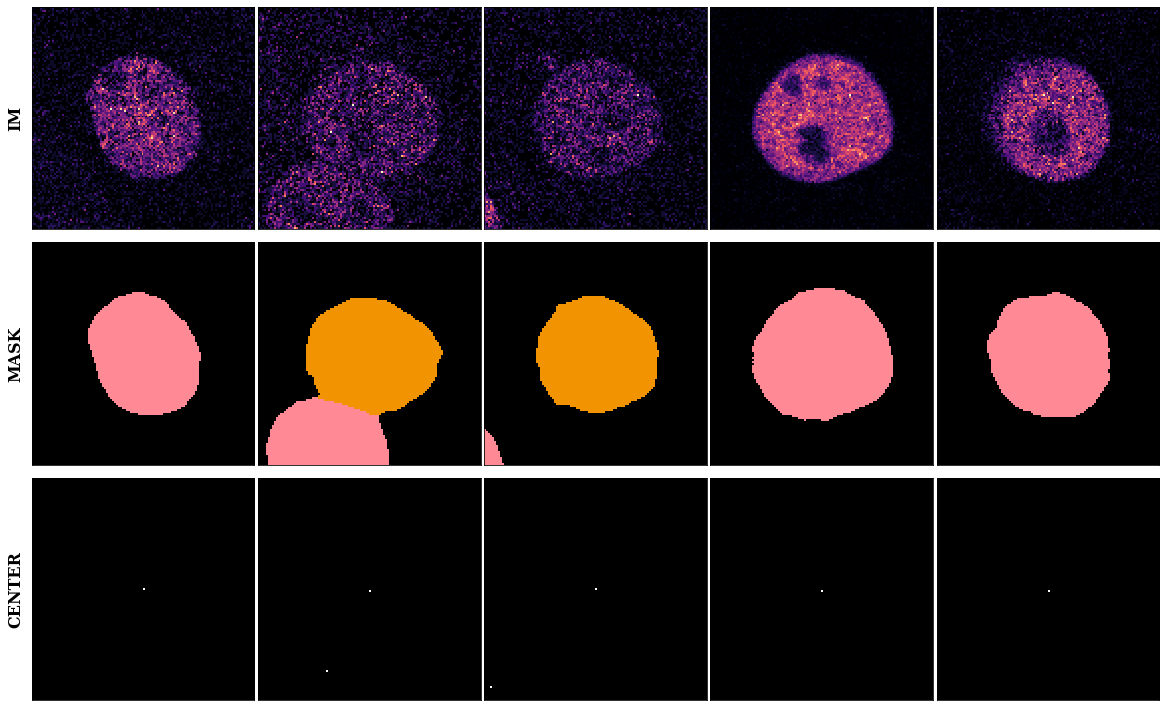

In [13]:
new_cmap = np.load('../../cmaps/cmap_60.npy')
new_cmap = ListedColormap(new_cmap) # new_cmap = 'magma' would also work! 
visualize_many_crops(data_dir=crops_dir, project_name=project_name, train_val_dir='val', center=center, n_images=5, new_cmp=new_cmap)

### Specify training dataset-related parameters

>We create a `train_dataset_dict` dictionary using the crops extracted from the train images and masks 

In [16]:
train_dataset_dict = create_dataset_dict(data_dir = crops_dir, 
                                         project_name = project_name,  
                                         center = center, 
                                         size = len(os.listdir(os.path.join(crops_dir, project_name, 'train', 'images'))), 
                                         batch_size = 16, 
                                         type = 'train')

`train_dataset_dict` dictionary successfully created with: 
 -- train images accessed from ./crops/Fluo-N2DH-GOWT1/train/images, 
 -- number of images per epoch equal to 176, 
 -- batch size set at 16, 
 -- virtual batch multiplier set as 1, 
 -- one_hot set as False, 


### Specify validation dataset-related parameters

>We create a `val_dataset_dict` dictionary using the crops extracted from the validation images and masks 

In [17]:
val_dataset_dict = create_dataset_dict(data_dir = crops_dir, 
                                       project_name = project_name, 
                                       center = center, 
                                       size = len(os.listdir(os.path.join(crops_dir, project_name, 'val', 'images'))), 
                                       batch_size = 16, 
                                       type ='val',)

`val_dataset_dict` dictionary successfully created with: 
 -- val images accessed from ./crops/Fluo-N2DH-GOWT1/val/images, 
 -- number of images per epoch equal to 280, 
 -- batch size set at 16, 
 -- virtual batch multiplier set as 1, 
 -- one_hot set as False, 


### Specify model-related parameters

>Set the `input_channels` attribute equal to the number of channels in the input images.  
In the cell after this one, a `model_dataset_dict` and a `loss_dict` dictionary is created.

In [18]:
model_dict = create_model_dict(input_channels = 1)
loss_dict = create_loss_dict()

`model_dict` dictionary successfully created with: 
 -- num of classes equal to 1, 
 -- input channels equal to [4, 1], 
 -- name equal to branched_erfnet
`loss_dict` dictionary successfully created with: 
 -- foreground weight equal to 10.000, 
 -- w_inst equal to 1, 
 -- w_var equal to 10, 
 -- w_seed equal to 1


### Specify the duration of training by setting `n_epochs`

>In the cell after this one, a `configs` dictionary is created.  
The model weights are saved by default at `experiment/Fluo-N2DH-GOWT1-demo`

In [23]:
n_epochs = 25

### Next, we load the pretrained model weights

>This model has been pre-trained on the `DSB` nuclei dataset

In [24]:
# use the following for the pretrained model weights
torch.hub.download_url_to_file(url = 'https://owncloud.mpi-cbg.de/index.php/s/H1pXwhq3aO4kJK3/download', 
                               dst = 'pretrained_model', progress=True)
import zipfile
with zipfile.ZipFile('pretrained_model', 'r') as zip_ref:
    zip_ref.extractall('')
checkpoint_path = os.path.join('dsb-2018'+'-'+'demo', 'best_iou_model.pth')

0.00B [00:00, ?B/s]

In [25]:
configs = create_configs(save_dir = os.path.join('experiment', project_name+'-'+'demo'), 
                         n_epochs=n_epochs,
                         resume_path=checkpoint_path,
                         n_y = n_y, 
                         n_x = n_x,
                         finetuning=True)

`configs` dictionary successfully created with: 
 -- n_epochs equal to 25, 
 -- display equal to False, 
 -- save_dir equal to experiment/Fluo-N2DH-GOWT1-demo, 
 -- n_z equal to None, 
 -- n_y equal to 1024, 
 -- n_x equal to 1024, 
 -- one_hot equal to False, 


### Begin training!

>We input the dictionaries created above to the `begin_training` function. 

In [26]:
%matplotlib Agg
begin_training(train_dataset_dict, val_dataset_dict, model_dict, loss_dict, configs)

2-D `train` dataloader created! Accessing data from ./crops/Fluo-N2DH-GOWT1/train/
Number of images in `train` directory is 176
Number of instances in `train` directory is 176
Number of center images in `train` directory is 176
*************************
2-D `val` dataloader created! Accessing data from ./crops/Fluo-N2DH-GOWT1/val/
Number of images in `val` directory is 280
Number of instances in `val` directory is 280
Number of center images in `val` directory is 280
*************************
Creating Branched Erfnet with [4, 1] outputs
Initialize last layer with size:  torch.Size([16, 4, 2, 2])
*************************
Created spatial emb loss function with: n_sigma: 2, foreground_weight: 10
*************************
Created logger with keys:  ('train', 'val', 'iou')
Resuming model from dsb-2018-demo/best_iou_model.pth
Previous best epoch was: 29
Starting epoch 150
learning rate: 0.00043424968050508256


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:09<00:00,  1.84it/s]


===> train loss: 0.37
===> val loss: 0.28, val iou: 0.89
=> saving checkpoint
Starting epoch 151
learning rate: 0.0004977494364660346


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.65it/s]


===> train loss: 0.25
===> val loss: 0.25, val iou: 0.91
=> saving checkpoint
Starting epoch 152
learning rate: 0.0004954977417064171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  5.33it/s]


===> train loss: 0.26
===> val loss: 0.27, val iou: 0.91
=> saving checkpoint
Starting epoch 153
learning rate: 0.0004932449094349202


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  5.90it/s]


===> train loss: 0.24
===> val loss: 0.30, val iou: 0.90
=> saving checkpoint
Starting epoch 154
learning rate: 0.0004909909332982877


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.30it/s]


===> train loss: 0.22
===> val loss: 0.20, val iou: 0.91
=> saving checkpoint
Starting epoch 155
learning rate: 0.0004887358068751748


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.00it/s]


===> train loss: 0.20
===> val loss: 0.21, val iou: 0.92
=> saving checkpoint
Starting epoch 156
learning rate: 0.0004864795236750653


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.42it/s]


===> train loss: 0.20
===> val loss: 0.18, val iou: 0.92
=> saving checkpoint
Starting epoch 157
learning rate: 0.00048422207713716544


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.71it/s]


===> train loss: 0.19
===> val loss: 0.18, val iou: 0.92
=> saving checkpoint
Starting epoch 158
learning rate: 0.00048196346062927547


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  5.21it/s]


===> train loss: 0.17
===> val loss: 0.15, val iou: 0.94
=> saving checkpoint
Starting epoch 159
learning rate: 0.00047970366744663594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.20it/s]


===> train loss: 0.18
===> val loss: 0.17, val iou: 0.92
=> saving checkpoint
Starting epoch 160
learning rate: 0.00047744269081074987


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.15it/s]


===> train loss: 0.17
===> val loss: 0.17, val iou: 0.93
=> saving checkpoint
Starting epoch 161
learning rate: 0.0004751805238681794


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  5.38it/s]


===> train loss: 0.19
===> val loss: 0.16, val iou: 0.93
=> saving checkpoint
Starting epoch 162
learning rate: 0.000472917159689316


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  5.67it/s]


===> train loss: 0.16
===> val loss: 0.15, val iou: 0.93
=> saving checkpoint
Starting epoch 163
learning rate: 0.00047065259126712457


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  5.57it/s]


===> train loss: 0.15
===> val loss: 0.17, val iou: 0.92
=> saving checkpoint
Starting epoch 164
learning rate: 0.00046838681151585874


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:05<00:00,  2.91it/s]


===> train loss: 0.16
===> val loss: 0.14, val iou: 0.93
=> saving checkpoint
Starting epoch 165
learning rate: 0.0004661198132697498


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  3.57it/s]


===> train loss: 0.18
===> val loss: 0.16, val iou: 0.93
=> saving checkpoint
Starting epoch 166
learning rate: 0.0004638515892816641


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.69it/s]


===> train loss: 0.16
===> val loss: 0.15, val iou: 0.93
=> saving checkpoint
Starting epoch 167
learning rate: 0.00046158213222173284


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.04it/s]


===> train loss: 0.16
===> val loss: 0.14, val iou: 0.93
=> saving checkpoint
Starting epoch 168
learning rate: 0.0004593114346759497


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.49it/s]


===> train loss: 0.15
===> val loss: 0.13, val iou: 0.93
=> saving checkpoint
Starting epoch 169
learning rate: 0.00045703948914473726


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.06it/s]


===> train loss: 0.15
===> val loss: 0.13, val iou: 0.93
=> saving checkpoint
Starting epoch 170
learning rate: 0.00045476628804148113


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.78it/s]


===> train loss: 0.15
===> val loss: 0.14, val iou: 0.93
=> saving checkpoint
Starting epoch 171
learning rate: 0.00045249182369103055


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  5.16it/s]


===> train loss: 0.15
===> val loss: 0.15, val iou: 0.93
=> saving checkpoint
Starting epoch 172
learning rate: 0.00045021608832816447


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:05<00:00,  2.86it/s]


===> train loss: 0.15
===> val loss: 0.14, val iou: 0.94
=> saving checkpoint
Starting epoch 173
learning rate: 0.0004479390740960227


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.40it/s]


===> train loss: 0.16
===> val loss: 0.16, val iou: 0.94
=> saving checkpoint
Starting epoch 174
learning rate: 0.00044566077304449995


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  5.04it/s]


===> train loss: 0.14
===> val loss: 0.16, val iou: 0.92
=> saving checkpoint


In [27]:
checkpoint_path = os.path.join('experiment', project_name+'-'+'demo', 'best_iou_model.pth')

### Set `tta=True` for better inference

> Setting `tta=True` leads to improved performance, but the trained model takes *longer* to predict per image.  
We set the location where the predictions of the test images are saved with `save_dir`.  
In the cell after this one, a `test_configs` dictionary is created.

In [28]:
tta = True
save_dir = './inference/' + project_name

In [29]:
test_configs = create_test_configs_dict(data_dir = os.path.join(data_dir, project_name),
                                        checkpoint_path = checkpoint_path,
                                        tta = tta, 
                                        min_object_size = min_object_size, 
                                        save_dir = save_dir,
                                        norm = norm, 
                                        data_type = data_type,
                                        n_y = n_y,
                                        n_x = n_x,
                                       )

`test_configs` dictionary successfully created with: 
 -- evaluation images accessed from ../../data/Fluo-N2DH-GOWT1, 
 -- trained weights accessed from experiment/Fluo-N2DH-GOWT1-demo/best_iou_model.pth, 
 -- output directory chosen as ./inference/Fluo-N2DH-GOWT1


### Evaluate on unseen test data

>The `test_configs` dictionary created above, is input to the `begin_evaluating` function.

In [30]:
%matplotlib inline
result = begin_evaluating(test_configs)

2-D `test` dataloader created! Accessing data from ../../data/Fluo-N2DH-GOWT1/test/
Number of images in `test` directory is 92
Number of instances in `test` directory is 92
Number of center images in `test` directory is 0
*************************
Creating Branched Erfnet with [4, 1] outputs


  1%|█▏                                                                                                            | 1/92 [00:04<06:27,  4.26s/it]

Created new directory ./inference/Fluo-N2DH-GOWT1/predictions/
Created new directory ./inference/Fluo-N2DH-GOWT1/ground-truth/
Created new directory ./inference/Fluo-N2DH-GOWT1/seeds/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [03:23<00:00,  2.21s/it]

Created new directory ./inference/Fluo-N2DH-GOWT1/results/
Mean Average Precision (AP_dsb) at IOU threshold = 0.5 at foreground threshold = 0.50000, is equal to 0.27716


In [32]:
%matplotlib inline
prediction_file_names = sorted(glob(os.path.join(save_dir,'predictions','*.tif')))
ground_truth_file_names = sorted(glob(os.path.join(save_dir,'ground-truth','*.tif')))
seed_file_names = sorted(glob(os.path.join(save_dir,'seeds','*.tif')))
image_file_names = sorted(glob(os.path.join(data_dir, project_name, 'test', 'images','*.tif')))

### Visualize some results on unseen test data

>Change value of `index` to see predictions on different unseen, test images.

Image filename is t000.tif and index is 0


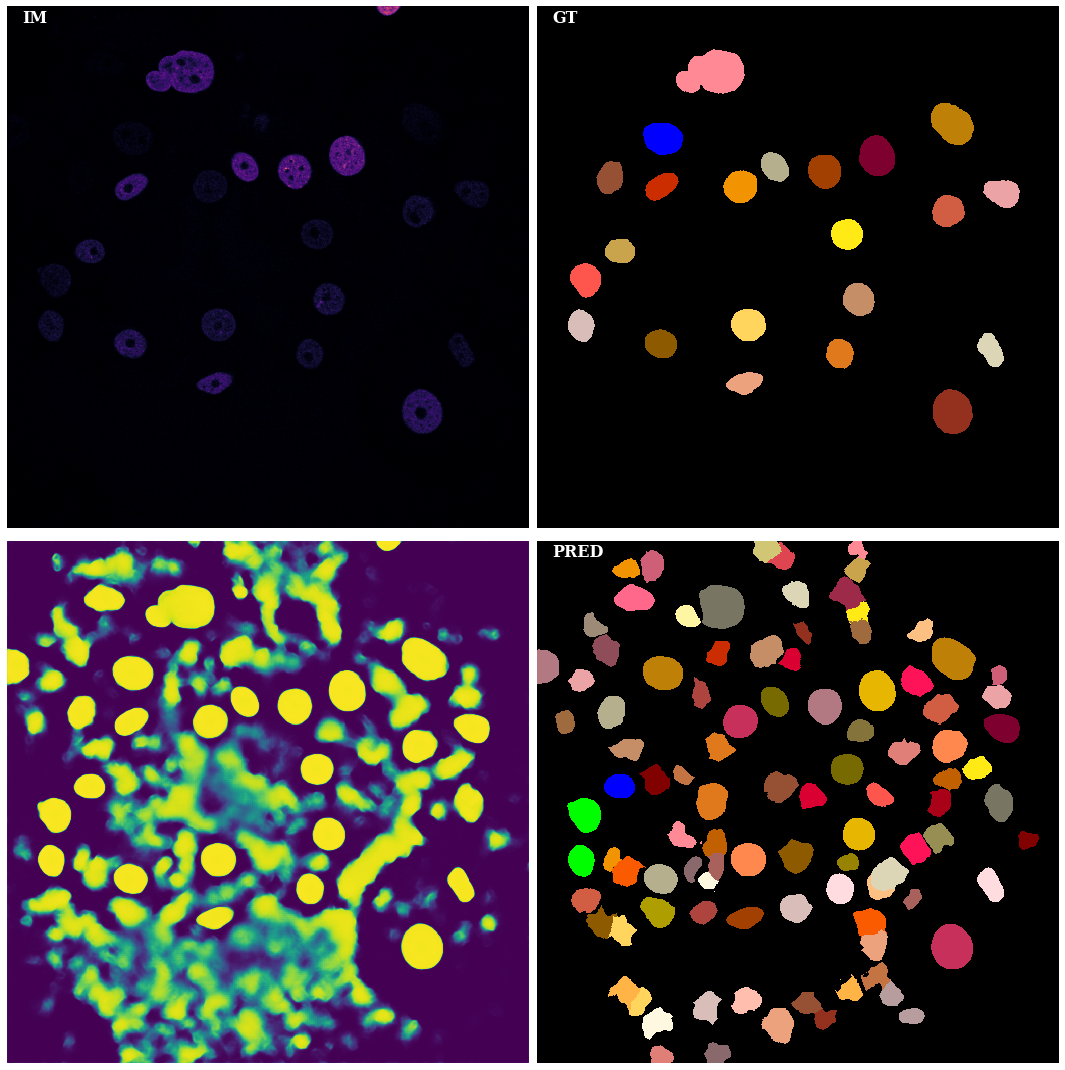

In [38]:
index = 0
print("Image filename is {} and index is {}".format(os.path.basename(image_file_names[index]), index))
prediction = tifffile.imread(prediction_file_names[index])
image = tifffile.imread(image_file_names[index])
seed = tifffile.imread(seed_file_names[index])
if len(ground_truth_file_names) > 0:
    ground_truth = tifffile.imread(ground_truth_file_names[index])
    visualize(image = image, prediction = prediction, ground_truth = ground_truth, seed = seed, new_cmp = new_cmap)
else:
    visualize(image = image, prediction = prediction, ground_truth = None, seed = seed, new_cmp = new_cmap)

<div class="alert alert-block alert-info"> <b> Does finetuning really help? </b> <br>
Try going back and setting <i>resume_path=None</i> to train a model <u>from scratch</u> for the same duration ($50$ epochs). <br>
What do you notice?

In [39]:
# Try the resume_path=None option and train a new model from scratch
configs_no_resume = create_configs(save_dir = os.path.join('experiment', project_name+'-'+'demo'), 
                         n_epochs=n_epochs,
                         resume_path=None,
                         n_y = n_y, 
                         n_x = n_x,
                         finetuning=True)

`configs` dictionary successfully created with: 
 -- n_epochs equal to 25, 
 -- display equal to False, 
 -- save_dir equal to experiment/Fluo-N2DH-GOWT1-demo, 
 -- n_z equal to None, 
 -- n_y equal to 1024, 
 -- n_x equal to 1024, 
 -- one_hot equal to False, 


In [40]:
%matplotlib Agg
begin_training(train_dataset_dict, val_dataset_dict, model_dict, loss_dict, configs_no_resume)

2-D `train` dataloader created! Accessing data from ./crops/Fluo-N2DH-GOWT1/train/
Number of images in `train` directory is 176
Number of instances in `train` directory is 176
Number of center images in `train` directory is 176
*************************
2-D `val` dataloader created! Accessing data from ./crops/Fluo-N2DH-GOWT1/val/
Number of images in `val` directory is 280
Number of instances in `val` directory is 280
Number of center images in `val` directory is 280
*************************
Creating Branched Erfnet with [4, 1] outputs
Initialize last layer with size:  torch.Size([16, 4, 2, 2])
*************************
Created spatial emb loss function with: n_sigma: 2, foreground_weight: 10
*************************
Created logger with keys:  ('train', 'val', 'iou')
Starting epoch 0
learning rate: 0.0005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  5.69it/s]


===> train loss: 2.21
===> val loss: 2.24, val iou: 0.10
=> saving checkpoint
Starting epoch 1
learning rate: 0.0004977494364660346


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  5.60it/s]


===> train loss: 1.89
===> val loss: 2.16, val iou: 0.10
=> saving checkpoint
Starting epoch 2
learning rate: 0.0004954977417064171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.08it/s]


===> train loss: 1.32
===> val loss: 1.90, val iou: 0.16
=> saving checkpoint
Starting epoch 3
learning rate: 0.0004932449094349202


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.28it/s]


===> train loss: 0.94
===> val loss: 1.42, val iou: 0.38
=> saving checkpoint
Starting epoch 4
learning rate: 0.0004909909332982877


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  5.84it/s]


===> train loss: 0.83
===> val loss: 1.06, val iou: 0.56
=> saving checkpoint
Starting epoch 5
learning rate: 0.0004887358068751748


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:05<00:00,  2.93it/s]


===> train loss: 0.74
===> val loss: 0.75, val iou: 0.74
=> saving checkpoint
Starting epoch 6
learning rate: 0.0004864795236750653


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.64it/s]


===> train loss: 0.71
===> val loss: 0.68, val iou: 0.74
=> saving checkpoint
Starting epoch 7
learning rate: 0.00048422207713716544


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  5.01it/s]


===> train loss: 0.62
===> val loss: 0.57, val iou: 0.81
=> saving checkpoint
Starting epoch 8
learning rate: 0.00048196346062927547


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.67it/s]


===> train loss: 0.57
===> val loss: 0.48, val iou: 0.82
=> saving checkpoint
Starting epoch 9
learning rate: 0.00047970366744663594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.10it/s]


===> train loss: 0.57
===> val loss: 0.48, val iou: 0.82
=> saving checkpoint
Starting epoch 10
learning rate: 0.00047744269081074987


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.08it/s]


===> train loss: 0.49
===> val loss: 0.50, val iou: 0.82
=> saving checkpoint
Starting epoch 11
learning rate: 0.0004751805238681794


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  5.30it/s]


===> train loss: 0.49
===> val loss: 0.53, val iou: 0.81
=> saving checkpoint
Starting epoch 12
learning rate: 0.000472917159689316


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.46it/s]


===> train loss: 0.47
===> val loss: 0.38, val iou: 0.85
=> saving checkpoint
Starting epoch 13
learning rate: 0.00047065259126712457


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.68it/s]


===> train loss: 0.46
===> val loss: 0.38, val iou: 0.86
=> saving checkpoint
Starting epoch 14
learning rate: 0.00046838681151585874


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:11<00:00,  1.53it/s]


===> train loss: 0.41
===> val loss: 0.37, val iou: 0.87
=> saving checkpoint
Starting epoch 15
learning rate: 0.0004661198132697498


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  3.75it/s]


===> train loss: 0.42
===> val loss: 0.36, val iou: 0.87
=> saving checkpoint
Starting epoch 16
learning rate: 0.0004638515892816641


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  5.82it/s]


===> train loss: 0.40
===> val loss: 0.32, val iou: 0.86
=> saving checkpoint
Starting epoch 17
learning rate: 0.00046158213222173284


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  3.99it/s]


===> train loss: 0.41
===> val loss: 0.30, val iou: 0.89
=> saving checkpoint
Starting epoch 18
learning rate: 0.0004593114346759497


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  5.04it/s]


===> train loss: 0.36
===> val loss: 0.37, val iou: 0.85
=> saving checkpoint
Starting epoch 19
learning rate: 0.00045703948914473726


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  3.95it/s]


===> train loss: 0.39
===> val loss: 0.37, val iou: 0.85
=> saving checkpoint
Starting epoch 20
learning rate: 0.00045476628804148113


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  5.59it/s]


===> train loss: 0.39
===> val loss: 0.45, val iou: 0.83
=> saving checkpoint
Starting epoch 21
learning rate: 0.00045249182369103055


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.67it/s]


===> train loss: 0.44
===> val loss: 0.34, val iou: 0.87
=> saving checkpoint
Starting epoch 22
learning rate: 0.00045021608832816447


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:05<00:00,  2.92it/s]


===> train loss: 0.40
===> val loss: 0.39, val iou: 0.83
=> saving checkpoint
Starting epoch 23
learning rate: 0.0004479390740960227


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  5.50it/s]


===> train loss: 0.38
===> val loss: 0.41, val iou: 0.85
=> saving checkpoint
Starting epoch 24
learning rate: 0.00044566077304449995


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  5.30it/s]


===> train loss: 0.38
===> val loss: 0.33, val iou: 0.87
=> saving checkpoint


In [42]:
test_configs_no_resume = create_test_configs_dict(data_dir = os.path.join(data_dir, project_name),
                                        checkpoint_path = checkpoint_path,
                                        tta = tta, 
                                        min_object_size = min_object_size, 
                                        save_dir = save_dir,
                                        norm = norm, 
                                        data_type = data_type,
                                        n_y = n_y,
                                        n_x = n_x,
                                       )

`test_configs` dictionary successfully created with: 
 -- evaluation images accessed from ../../data/Fluo-N2DH-GOWT1, 
 -- trained weights accessed from experiment/Fluo-N2DH-GOWT1-demo/best_iou_model.pth, 
 -- output directory chosen as ./inference/Fluo-N2DH-GOWT1


In [43]:
%matplotlib inline
result = begin_evaluating(test_configs_no_resume)

2-D `test` dataloader created! Accessing data from ../../data/Fluo-N2DH-GOWT1/test/
Number of images in `test` directory is 92
Number of instances in `test` directory is 92
Number of center images in `test` directory is 0
*************************
Creating Branched Erfnet with [4, 1] outputs


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:17<00:00,  1.19it/s]

Mean Average Precision (AP_dsb) at IOU threshold = 0.5 at foreground threshold = 0.50000, is equal to 0.59272


In [44]:
%matplotlib inline
prediction_file_names = sorted(glob(os.path.join(save_dir,'predictions','*.tif')))
ground_truth_file_names = sorted(glob(os.path.join(save_dir,'ground-truth','*.tif')))
seed_file_names = sorted(glob(os.path.join(save_dir,'seeds','*.tif')))
image_file_names = sorted(glob(os.path.join(data_dir, project_name, 'test', 'images','*.tif')))

Image filename is t000.tif and index is 0


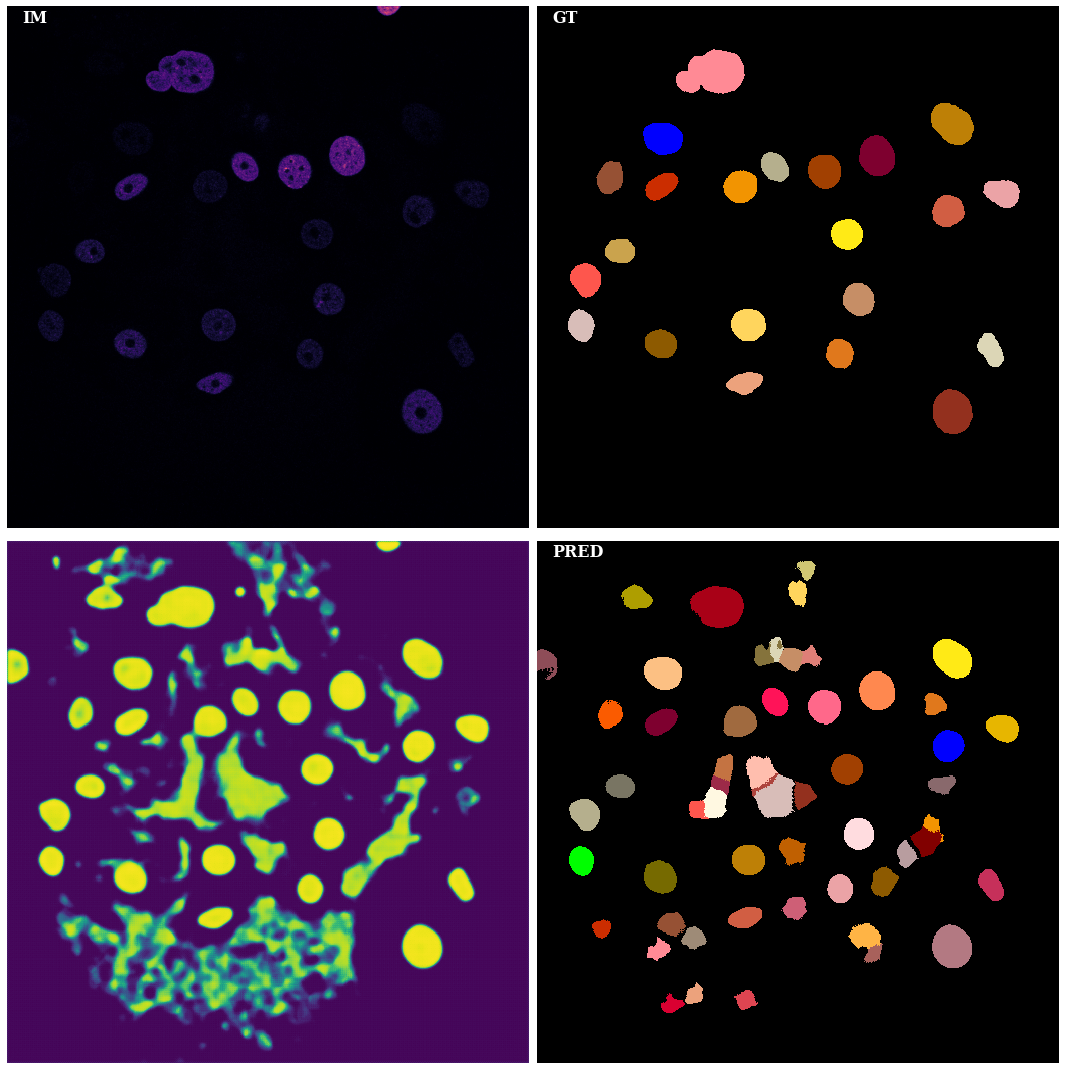

In [45]:
index = 0
print("Image filename is {} and index is {}".format(os.path.basename(image_file_names[index]), index))
prediction = tifffile.imread(prediction_file_names[index])
image = tifffile.imread(image_file_names[index])
seed = tifffile.imread(seed_file_names[index])
if len(ground_truth_file_names) > 0:
    ground_truth = tifffile.imread(ground_truth_file_names[index])
    visualize(image = image, prediction = prediction, ground_truth = ground_truth, seed = seed, new_cmp = new_cmap)
else:
    visualize(image = image, prediction = prediction, ground_truth = None, seed = seed, new_cmp = new_cmap)